## Preparação de dados do TCU

Versao inicial: Fernando Melo - 10/09/2018

Versao atualizada: Monique Monteiro - 16/09/2018. 

- Uso do language model para WIKI-PT disponivel em https://github.com/monilouise/deep-learning/tree/master/nlp/language-models/pt
- Uso de 1cycle para tunning do language model

Dados disponíveis no site: https://contas.tcu.gov.br/pesquisaJurisprudencia/#/pesquisa/jurisprudencia-selecionada

In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from os.path import isfile, join
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from fastai.text import *
import html


In [3]:
import spacy
nlp = spacy.load('pt')



    Only loading the 'pt' tokenizer.



In [4]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Reading data 

In [5]:
# set path for classification files
CLAS_PATH=Path('data/tcu/dist_class')
CLAS_PATH.mkdir(exist_ok=True)

# set path for language model files
LM_PATH=Path('data/tcu/dist_lm/')
LM_PATH.mkdir(exist_ok=True)

In [6]:
PATH = 'data/tcu/'
df = pd.read_csv(PATH+'tcu_jurisp.csv', index_col=0) 

In [7]:
df.shape

(13258, 2)

In [8]:
df.head()

,labels,text
0,6,O TCU tem competência para fiscalizar a aplica...
1,6,"Não compete ao TCU apreciar, para fins de regi..."
2,6,Compete ao TCU a apreciação da constitucionali...
3,6,É possível a expedição de determinação pelo TC...
4,6,"O TCU não tem competência, no âmbito do Progra..."


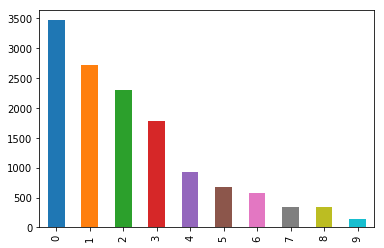

In [9]:
df['labels'].value_counts().plot.bar()

In [10]:
df['labels'].value_counts()

0    3468
1    2723
2    2297
3    1775
4     932
5     673
6     572
7     343
8     337
9     138
Name: labels, dtype: int64

In [11]:
# save new file distribuicao.csv for future use
df.to_csv(PATH+'distrib.csv')

In [12]:
df.head()

,labels,text
0,6,O TCU tem competência para fiscalizar a aplica...
1,6,"Não compete ao TCU apreciar, para fins de regi..."
2,6,Compete ao TCU a apreciação da constitucionali...
3,6,É possível a expedição de determinação pelo TC...
4,6,"O TCU não tem competência, no âmbito do Progra..."


## Spliting data in train and test datasets for CLASSIFICATION ONLY

In [13]:
df_reduz = pd.read_csv(PATH+'tcu_jurisp_reduzido.csv', index_col=0)

In [14]:
df_reduz.shape

(10263, 2)

In [15]:
df_reduz['labels'].value_counts()

0    3468
1    2723
2    2297
3    1775
Name: labels, dtype: int64

In [16]:
train,test = train_test_split(df_reduz, test_size=0.1)

In [17]:
# save train and test of tcu_jurisp.csv for future use
# test dataset will have 10%  of the total rows of the orginal dataset.
test.to_csv(PATH+'test_tcu_jurisp.csv')
train.to_csv(PATH+'train_tcu_jurisp.csv')

In [18]:
test.shape

(1027, 2)

In [19]:
train.shape

(9236, 2)

## Classification data preparation

In [20]:
CLASSES = ['Pessoal', 'Licitação', 'Responsabilidade','Direito_Processual']

In [21]:
# Append texts and labels from TRAIN dataset and create numpy array
trn_texts = np.array(train['text'])
trn_labels = np.array(train['labels'])
# Append texts and labels from TEST dataset and create numpy array
val_texts = np.array(test['text'])
val_labels = np.array(test['labels'])


In [22]:
len(trn_texts), len(val_texts)

(9236, 1027)

In [23]:
trn_texts[0:10]

array([ 'O desbalanceamento entre critérios de técnica e preço torna possível o direcionamento da licitação, restringindo a competitividade e, consequentemente, o número de propostas apresentadas.',
       'Os dependentes de ex-servidores ferroviários autárquicos não têm direito à pensão custeada pelo Tesouro Nacional.',
       'O exame de admissibilidade do recurso, no que se refere à tempestividade, estará prejudicado no caso de ausência da data do recebimento da comunicação da decisão pelo responsável.',
       'É irregular o cumprimento de jornada de trabalho de sete horas por ocupantes de cargos em comissão e funções de confiança. Os servidores que exercem função de confiança ou ocupam cargo em comissão estão sujeitos ao cumprimento da jornada de quarenta horas semanais, por estarem submetidos a regime de integral dedicação ao serviço.',
       'Os índices contábeis somente devem ser exigidos em nível suficiente para assegurar o cumprimento das obrigações, devendo, ainda, ser acom

In [24]:
trn_labels[0:10]

array([1, 0, 3, 0, 1, 0, 0, 0, 1, 0])

In [25]:
col_names = ['labels','text']

Random permutation np array to shuffle the text.  
Text and labels have to be permutated in the same way and that's why we're going to set the seed.

In [26]:
# Random permutation of train and test texts
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [27]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [28]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [29]:
df_val.head()

,labels,text
0,0,É ilegal a aposentadoria que não preencha o re...
1,0,A aplicação do princípio da segurança jurídica...
2,0,Com a edição da Emenda Constitucional nº 41/20...
3,0,Deve ser aplicado concurso público para a sele...
4,3,Para se configurar hipótese de impedimento do ...


The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns.

In [30]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

## Language model data preparation

Creating the data for the Language Model(LM). The LM's goal is to learn the structure of the portuguese language. It learns language by trying to predict the next word given a set of previous words(ngrams). Since the LM does not classify reviews, the labels can be ignored.

The LM can benefit from all the textual data and there is no need to exclude text.

We first concat all the train(81,349) and test(20,400) texts. And then, we use sklearn splitter to divide up the 101,749 texts into 90% training and 10% validation sets.  

It's important to mention that this is for the LM preparation and that, for the classification we'll use test.csv, which has 20,400 rows that we prepared above.

In [31]:
df_text = np.array(df.text)

In [32]:
df_text.shape

(13258,)

In [33]:
# trn_texts,val_texts = sklearn.model_selection.train_test_split(
#     np.concatenate([trn_texts,val_texts]), test_size=0.1)

trn_texts,val_texts = train_test_split(df_text, test_size=0.1)

In [34]:
len(trn_texts), len(val_texts)

(11932, 1326)

In [35]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language model tokenization

In [36]:
chunksize=24000

In [37]:
import re

In [38]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [39]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer(lang='pt').proc_all_mp(partition_by_cores(texts),lang='pt')
    return tok, list(labels)

In [40]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [41]:
!cat ~/fastai/courses/dl2/fastai/text.py

from .core import *
from .learner import *
from .lm_rnn import *
from torch.utils.data.sampler import Sampler
import spacy
from spacy.symbols import ORTH

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

def texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    return texts, np.array(labels).astype(np.int64)

def numericalize_tok(tokens, max_vocab=50000, min_freq=0, unk_tok="_unk_", pad_tok="_pad_", bos_tok="_bos_", eos_tok="_eos_"):
    """Takes in text tokens and returns int2tok and tok2int converters

        Arguments:
        tokens(list): List of tokens. Can be a list of strings, or a list of lists of strings.
        max_vocab(int): Number of tokens to return in the vocab (sorted by frequency)
        min_freq

In [42]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [43]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0


    Only loading the 'pt' tokenizer.






    Only loading the 'pt' tokenizer.

    Only loading the 'pt' tokenizer.


    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.




    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.

    Only loading the 'pt' tokenizer.


0


    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.




    Only loading the 'pt' tokenizer.


    Only loading the 'pt' tokenizer.



In [44]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [45]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [46]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [47]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('de', 38627),
 (',', 36991),
 ('a', 28455),
 ('.', 17706),
 ('o', 15294),
 ('da', 14275),
 ('do', 12986),
 ('1', 12050),
 ('\n', 11932),
 ('xbos', 11932),
 ('xfld', 11932),
 ('e', 10487),
 ('que', 8291),
 ('em', 7128),
 ('não', 7028),
 ('/', 6573),
 ('para', 5930),
 ('os', 5402),
 ('t_up', 5344),
 ('no', 4913),
 ('se', 4421),
 ('ou', 4377),
 ('com', 4376),
 ('à', 4297),
 ('dos', 4173)]

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [48]:
max_vocab = 60000
min_freq = 2

In [49]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [50]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

8290

In [51]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [52]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [53]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [54]:
vs=len(itos)
vs,len(trn_lm)

(8290, 11932)

In [55]:
' '.join(tok_trn[0]+tok_trn[1]+tok_trn[2]+tok_trn[3]+tok_trn[4])

'\n xbos xfld 1 quando deliberação do t_up tcu atingir interesse subjetivo de servidores de categoria profissional representada por sindicato , deve ser autorizada a habilitação da entidade representativa nos autos como interessado , para o exercício de prerrogativas processuais . \n xbos xfld 1 o teor do memorial previsto no art . 160 , § 3º , do regimento interno do t_up tcu pode ser considerado ou ignorado pelo relator , a seu exclusivo juízo , sem que a negativa represente prejuízo à defesa ou nulidade da deliberação proferida , porque essa peça , de caráter meramente informativo , não se confunde com aquela prevista no art . 454 , § 3º , do t_up cpc . \n xbos xfld 1 caso comprovado que o ente federado se beneficiou pela aplicação irregular dos recursos , o t_up tcu , a o proferir o julgamento de mérito , deverá condenar diretamente o estado , o distrito federal ou o município , ou a entidade de sua administração , a o pagamento do débito . \n xbos xfld 1 as microempresas , a o pre

In [56]:
' '.join(str(o) for o in trn_lm[0:4])

'[10, 11, 12, 9, 48, 395, 8, 20, 38, 3840, 226, 1499, 2, 95, 2, 1158, 305, 0, 29, 5709, 3, 39, 33, 2186, 4, 332, 7, 121, 7123, 47, 319, 43, 465, 3, 18, 6, 94, 2, 3647, 1434, 5] [10, 11, 12, 9, 6, 1673, 8, 3306, 314, 21, 32, 5, 3051, 3, 53, 192, 3, 8, 462, 298, 8, 20, 38, 63, 33, 677, 23, 4518, 40, 901, 3, 4, 100, 1927, 511, 3, 60, 14, 4, 1366, 3841, 228, 25, 203, 23, 796, 7, 395, 1612, 3, 1517, 144, 2840, 3, 2, 188, 987, 4855, 3, 16, 22, 1613, 24, 760, 132, 21, 32, 5, 0, 3, 53, 192, 3, 8, 20, 1548, 5] [10, 11, 12, 9, 61, 889, 14, 6, 303, 950, 22, 2762, 41, 58, 165, 26, 42, 3, 6, 20, 38, 3, 4, 6, 6295, 6, 126, 2, 344, 3, 640, 3842, 658, 6, 523, 3, 6, 687, 51, 23, 6, 529, 3, 23, 4, 121, 2, 52, 44, 3, 4, 6, 72, 8, 79, 5] [10, 11, 12, 9, 36, 2510, 3, 4, 6, 6296, 46, 14, 2022, 1240, 2, 823, 2, 137, 3, 16, 234, 3477, 30, 22, 26, 454, 3052, 1319, 4, 6, 786, 235, 3, 15, 218, 7, 824, 1674, 21, 32, 5, 1734, 3, 55, 20, 4856, 3, 7, 28, 315, 1675, 17, 705, 5, 271, 289, 1892, 15, 208, 3, 595, 3, 56,

## Wikipedia model: ptwiki_nandobr conversion

The pre-trained wiki LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target TCU LM so that the weights can be loaded up.

In [57]:
em_sz,nh,nl = 400,1150,3

In [58]:
#PRE_PATH = Path('data/wiki/pt/models/')
#PRE_LM_PATH = PRE_PATH/'ptwiki_nandobrbest.h5'

PRE_PATH = Path('/home/paperspace/fastai/courses/dl2/lm/pt/data/models/')
PRE_LM_PATH = PRE_PATH/'lm_PT_1_cycle_10_epochs_from_scratch.h5'

In [59]:
PRE_LM_PATH

PosixPath('/home/paperspace/fastai/courses/dl2/lm/pt/data/models/lm_PT_1_cycle_10_epochs_from_scratch.h5')

In [60]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target TCU LM.

In [61]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [62]:
itos2 = pickle.load(Path('/home/paperspace/fastai/courses/dl2/lm/pt/pt_lm/tmp/itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the TCU LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown Senado tokens that do not exist in ptwiki_nandobr.

In [63]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [64]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new TCU language pytorch model!

## TCU Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the Senado LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

In [65]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.SGD, momentum=0.9)

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

In [66]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

In [68]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [90]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [91]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [92]:
lr=1e-3
lrs = lr

In [93]:
learner.lr_find2(num_it=1400)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

 69%|██████▉   | 126/182 [00:28<00:12,  4.45it/s, loss=3.93]

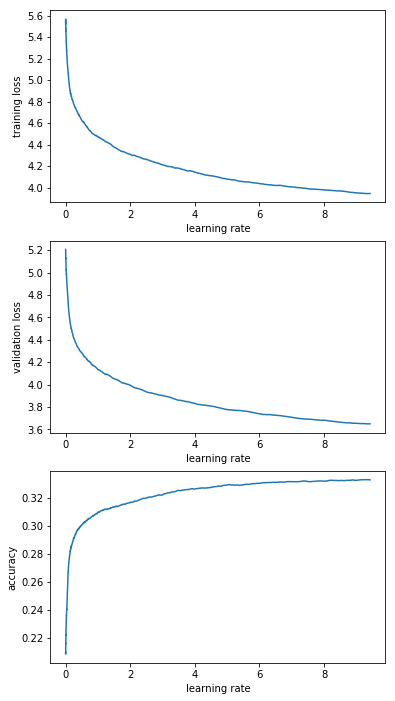

In [94]:
learner.sched.plot()

In [97]:
lr = 8

In [98]:
%%time
learner.fit(lr, 1, use_clr_beta=(10,10,0.95,0.85), cycle_len=1)


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  5%|▍         | 9/182 [00:01<00:27,  6.31it/s, loss=5.28]

Exception in thread Thread-19:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      3.975717   3.529724   0.348647  

CPU times: user 23.5 s, sys: 4.57 s, total: 28 s
Wall time: 27.9 s


[array([ 3.52972]), 0.34864699738869803]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [99]:
learner.save('lm_last_ft_1cycle')

In [102]:
learner.load('lm_last_ft_1cycle')

In [103]:
learner.unfreeze()

In [104]:
%%time
learner.fit(lr, 1, use_clr_beta=(10,10,0.95,0.85), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.540647   3.214119   0.38048   
    1      3.284075   3.023267   0.403596                   
    2      3.084933   2.895162   0.41856                    
    3      2.924411   2.794134   0.429844                   
    4      2.784499   2.722496   0.441786                   
    5      2.697022   2.668724   0.447352                   
    6      2.578886   2.627656   0.455371                   
    7      2.483772   2.603563   0.460834                   
    8      2.434822   2.554955   0.470049                   
    9      2.324437   2.540149   0.474669                   
    10     2.244621   2.515474   0.479029                   
    11     2.15786    2.497137   0.485367                   
    12     2.08489    2.476832   0.48989                    
    13     1.999878   2.45102    0.496323                   
    14     1.946395   2.435392   0.500882                   

CPU times: user 7min 31s, sys: 1min 34s,

[array([ 2.43539]), 0.50088159639240704]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [105]:
learner.save('lm1_1cycle')

In [106]:
learner.save_encoder('lm1_enc_1cycle')

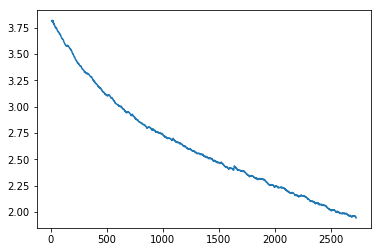

In [107]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [108]:
chunksize=24000

In [109]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [110]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0


    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.


    Only loading the 'pt' tokenizer.




    Only loading the 'pt' tokenizer.




    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.


    Only loading the 'pt' tokenizer.

0


    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.




    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.

    Only loading the 'pt' tokenizer.




    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.



    Only loading the 'pt' tokenizer.



In [111]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [112]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [113]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

8290

In [114]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [115]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDB backbone. The steps to create the classifier model are similar to the ones for the LM.

In [116]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [117]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [118]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [119]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [120]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [121]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [122]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [123]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [124]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [125]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [126]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [127]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [128]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc_1cycle')

In [129]:
learn.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 77%|███████▋  | 298/385 [00:13<00:04, 21.39it/s, loss=2.44] 

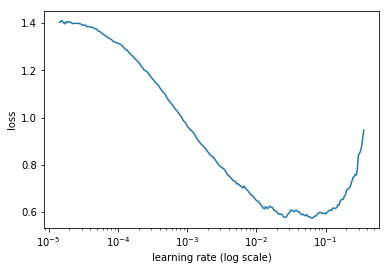

In [130]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [131]:
%%time
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 36%|███▋      | 140/385 [00:05<00:10, 23.47it/s, loss=0.489]

Exception in thread Thread-45:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.378833   0.206064   0.932245  

CPU times: user 14.7 s, sys: 2.6 s, total: 17.3 s
Wall time: 17.3 s


[array([ 0.20606]), 0.9322446334732355]

In [132]:
learn.save('clas_0_1cycle_lm')

In [133]:
learn.load('clas_0_1cycle_lm')

In [134]:
learn.freeze_to(-2)

In [135]:
%%time
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.344361   0.174365   0.938508  

CPU times: user 17.8 s, sys: 3.1 s, total: 20.9 s
Wall time: 20.4 s


[array([ 0.17437]), 0.938508090932341]

In [136]:
learn.save('clas_1_1cycle_lm')

In [137]:
learn.load('clas_1_1cycle_lm')

In [138]:
learn.unfreeze()

In [139]:
bs=24

In [140]:
%%time
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.291551   0.178712   0.930048  
    1      0.280122   0.163826   0.943516                    
    2      0.217225   0.138512   0.949557                    
    3      0.191473   0.132768   0.952385                    
    4      0.171641   0.123101   0.95458                     
    5      0.133568   0.13198    0.953363                    
    6      0.122197   0.118418   0.957824                    
    7      0.11683    0.122831   0.954388                     
    8      0.089443   0.112468   0.9618                       
    9      0.08371    0.1294     0.959057                     
    10     0.07602    0.120658   0.957809                     
    11     0.058307   0.124705   0.95995                      
    12     0.071666   0.123347   0.957955                     
    13     0.075409   0.124092   0.958132                     

CPU times: user 8min 32s, sys: 1min 32s, total: 10min 4s
Wall time: 10min 4s


[array([ 0.12409]), 0.95813220276458733]

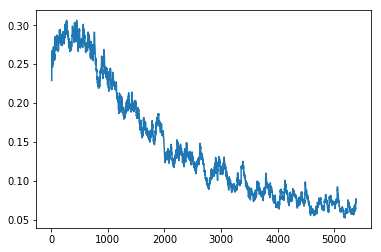

In [141]:
learn.sched.plot_loss()

In [142]:
learn.save('clas_2_1cycle_lm')

The previous state of the art result was 94.1% accuracy (5.9% error). With bidir we get 95.4% accuracy (4.6% error).

## End